# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [2]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [3]:
df_train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False


# expected_timeline - 4 + business관련 결측치 처리

expected_timeline : 고객의 요청한 처리 일정

1. 처리 날짜 : 0 ~ 3m 0 ~ 6m ...

2. 처리 상태 : requirement, response ...


In [4]:
df_train['expected_timeline'].isnull().sum()

30863

In [5]:
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

df_valid_rows = df_train.dropna(subset=['expected_timeline'])

text_data = ' '.join(df_valid_rows['expected_timeline'].astype(str))

# 토큰화 (단어 분리)
tokens = word_tokenize(text_data)

# 단어 빈도수 계산
word_freq = Counter(tokens)

word_freq

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dessert_gomjelly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Counter({'months': 30725,
         '3': 22288,
         'than': 20390,
         'less': 17366,
         '~': 7225,
         '6': 6235,
         'year': 4125,
         'a': 3035,
         'more': 3027,
         '9': 2200,
         '1': 1107,
         '.': 511,
         'to': 186,
         'the': 166,
         ',': 146,
         'client': 145,
         'with': 136,
         'not': 124,
         'for': 122,
         'is': 121,
         'details': 117,
         'up': 115,
         'in': 114,
         'followed': 98,
         'being': 97,
         'he': 95,
         'etc': 95,
         'shared': 85,
         'requirement': 81,
         'less_than_3_months': 76,
         'of': 75,
         'customer': 74,
         'and': 74,
         'demo': 65,
         'hence': 64,
         'will': 63,
         'on': 62,
         'system': 59,
         'call': 57,
         'no': 56,
         'are': 54,
         'idb': 50,
         'mailed': 46,
         'have': 43,
         'any': 41,
         'partner': 3

In [6]:
unique_values = df_train['expected_timeline'].nunique()


print(f"unique 값: {unique_values}")

value_counts = df_train['expected_timeline'].value_counts(dropna=False)

# 결과 출력
print("빈도:")
for value, count in zip(value_counts.index, value_counts.values):
    print(f"{value}: {count}")


unique 값: 449
빈도:
nan: 30863
less than 3 months: 17250
3 months ~ 6 months: 5026
more than a year: 3023
9 months ~ 1 year: 1101
6 months ~ 9 months: 1098
less than 6 months: 108
etc.: 95
less_than_3_months: 76
being followed up: 66
being followed up.: 24
the client is not having any requirement hence closig in system. although the details of idb are mailed to client.: 21
no requirement: 12
3_months_~_6_months: 9
didn't respond: 7
duplicate lead: 6
9_months_~_1_year: 6
forwarded to bdo, being followed up: 5
details send: 5
couldn't connect: 5
the client is not having any requirement, he was only browsing through the produt hence closig in system. although the details of idb are mailed to client.: 5
quote send: 5
details shared: 5
rnr: 5
6_months_~_9_months: 4
not answering call: 4
budget issue: 4
more_than_a_year: 4
details shared.: 3
not answering call, lead shared with rd: 3
assigned to partner. intial meeting done. will convert to opp post complete info: 3
not required: 3
already tou

# 요구 사항 분류 

- (requi'  'reqi') -> (requirement) && (not', 'no') -> (no requirement)
- (follow) 포함 -> (follow)
- (details)포함 -> (details shared)



# 커뮤니케이션 사항 분류 
- (didn't, not, no) + (reponse) -> (no response)
- (not answering) -> (no response)
- (call back, call later) -> (call back)




In [7]:
import pandas as pd

def update_expected_timeline(row):
    current_value = row['expected_timeline']

    if pd.notna(current_value):
        original_value = current_value
        updated_value = None

        if ('requi' in current_value or 'reqi' in current_value) and ('no' in current_value or 'not' in current_value):
            updated_value = 'no requirement'
        elif 'requi' in current_value or 'reqi' in current_value:
            updated_value = 'requirement'
        elif 'not' in current_value or 'no' in current_value:
            updated_value = 'no response'
        elif 'follow' in current_value:
            updated_value = 'follow'
        elif 'details' in current_value:
            updated_value = 'details shared'
        elif 'call back' in current_value or 'call later' in current_value:
            updated_value = 'call back'
        else:
            updated_value = original_value

        return updated_value

df_train['expected_timeline'] = df_train.apply(update_expected_timeline, axis=1)


In [8]:
timeline_mapping = {
    # 날짜
    "less than 3 months": "0-3m",
    "less_than_3_months": "0-3m",
    
    "3 months ~ 6 months": "3-6m",
    "3_months_~_6_months": "3-6m",
    
    "6 months ~ 9 months": "6-9m",
    "6_months_~_9_months": "6-9m",
    
    "9 months ~ 1 year": "9-12m",
    "9_months_~_1_year": "9-12m",

    "up to december": "1y",
    "more than a year": "1y",
    "more_than_a_year": "1y",

    "couldn't connect": "no response",
    "rnr": "no response",
    
    # 오타
    "reponse": "response"
}


df_train['expected_timeline'] = [timeline_mapping.get(label, label) for label in df_train['expected_timeline']]


In [9]:
unique_values = df_train['expected_timeline'].nunique()

print(f"unique 값: {unique_values}")

value_counts = df_train['expected_timeline'].value_counts(dropna=False)

# 결과 출력
print("빈도:")
for value, count in zip(value_counts.index, value_counts.values):
    print(f"{value}: {count}")


unique 값: 206
빈도:
None: 30863
0-3m: 17326
3-6m: 5035
1y: 3028
9-12m: 1107
6-9m: 1102
no response: 130
less than 6 months: 108
follow: 108
etc.: 95
no requirement: 66
requirement: 46
details shared: 45
call back: 15
didn't respond: 7
duplicate lead: 6
quote send: 5
budget issue: 4
already touch with customers: 3
assigned to partner. intial meeting done. will convert to opp post complete info: 3
december 2022: 3
less than 5 months: 2
fu under progress: 2
less then 6 months: 2
more then 3 months: 2
october 2022: 2
price shared: 2
low budget: 2
fu under progress.: 2
he is looking for interactive display. quote shared with him.: 1
exiting customer: 1
dind't respond: 1
tried contact him but couldn't able to connect. lead forwarded to rd: 1
quote shared for 86 inch. he is evaluation local brand of trueview: 1
drop, lookong for consumer product: 1
drop, wrong number: 1
uttarpradesh state lead: 1
discussed with the client they purchased 65um3df from the channel. unable to track the supplier. he

In [10]:
# 'expected_timeline' 열에서 값이 있는 행만 선택
df_valid_rows = df_train.dropna(subset=['expected_timeline'])

# 'expected_timeline' 열의 값을 모두 가져와서 텍스트로 결합
text_data = ' '.join(df_valid_rows['expected_timeline'].astype(str))

# 토큰화 (단어 분리)
tokens = word_tokenize(text_data)

# 단어 빈도수 계산
word_freq = Counter(tokens)

word_freq

Counter({'0-3m': 17326,
         '3-6m': 5035,
         '1y': 3028,
         '9-12m': 1107,
         '6-9m': 1102,
         '.': 205,
         'no': 196,
         'response': 130,
         'months': 122,
         'less': 113,
         'than': 113,
         'requirement': 112,
         '6': 110,
         'follow': 108,
         'etc': 95,
         'shared': 65,
         'to': 57,
         'with': 52,
         'for': 49,
         'details': 45,
         'is': 34,
         'demo': 33,
         'he': 32,
         'customer': 31,
         'the': 30,
         'in': 29,
         'will': 28,
         ',': 28,
         'and': 26,
         'call': 25,
         'client': 23,
         'budget': 21,
         'back': 19,
         'on': 19,
         'quote': 18,
         'already': 17,
         'they': 17,
         'partner': 15,
         'lead': 14,
         "n't": 13,
         'want': 13,
         'need': 12,
         'discussed': 12,
         'update': 12,
         'looking': 11,
         'him': 1

# *********** test 에 대해서도 실행 *******

In [11]:
def update_expected_timeline(row):
    current_value = row['expected_timeline']

    if pd.notna(current_value):
        original_value = current_value
        updated_value = None

        if ('requi' in current_value or 'reqi' in current_value) and ('no' in current_value or 'not' in current_value):
            updated_value = 'no requirement'
        elif 'requi' in current_value or 'reqi' in current_value:
            updated_value = 'requirement'
        elif 'not' in current_value or 'no' in current_value:
            updated_value = 'no response'
        elif 'follow' in current_value:
            updated_value = 'follow'
        elif 'details' in current_value:
            updated_value = 'details shared'
        elif 'call back' in current_value or 'call later' in current_value:
            updated_value = 'call back'
        else:
            updated_value = original_value

        return updated_value

df_test['expected_timeline'] = df_test.apply(update_expected_timeline, axis=1)


In [12]:
timeline_mapping = {
    # 날짜
    "less than 3 months": "0-3m",
    "less_than_3_months": "0-3m",
    
    "3 months ~ 6 months": "3-6m",
    "3_months_~_6_months": "3-6m",
    
    "6 months ~ 9 months": "6-9m",
    "6_months_~_9_months": "6-9m",
    
    "9 months ~ 1 year": "9-12m",
    "9_months_~_1_year": "9-12m",

    "up to december": "1y",
    "more than a year": "1y",
    "more_than_a_year": "1y",

    "couldn't connect": "no response",
    "rnr": "no response",
    
    # 오타
    "reponse": "response"
}


df_test['expected_timeline'] = [timeline_mapping.get(label, label) for label in df_test['expected_timeline']]


## 2. 데이터 전처리

### 레이블 인코딩

In [13]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [14]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [15]:
df_all

,customer_country,business_subarea,business_area,business_unit,customer_type,enterprise,customer_job,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline
0,9070,28,0,0,10,0,420,32,180,349,699,9070,47,33,1
1,8406,0,0,0,10,0,303,32,180,349,699,8406,21,33,1
2,6535,17,0,0,10,0,160,27,238,349,699,6535,80,21,1
3,3388,44,0,0,10,0,166,32,318,349,699,3388,21,21,1
4,5799,86,0,0,29,0,84,32,180,349,699,5799,80,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,10650,86,6,0,33,0,468,30,183,349,699,10650,9,43,11
5267,16640,86,6,3,33,0,323,30,183,349,699,16640,74,50,11
5268,1079,86,6,0,29,0,166,58,180,349,699,1079,64,43,1
5269,24,86,6,3,9,1,323,58,52,349,699,24,74,12,11


다시 학습 데이터와 제출 데이터를 분리합니다.

In [16]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [17]:
df_train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,9070,0,0.066667,32160,10,0,NaN,NaN,NaN,...,33,1,1,0,0.003079,0.026846,0,28,0,True
1,1.00,8406,0,0.066667,23122,10,0,12.0,NaN,NaN,...,33,1,1,0,0.003079,0.026846,0,0,1,True
2,1.00,6535,0,0.088889,1755,10,0,144.0,NaN,NaN,...,21,1,1,0,0.003079,0.026846,0,17,2,True
3,1.00,3388,0,0.088889,4919,10,0,NaN,NaN,NaN,...,21,1,1,0,0.003079,0.026846,0,44,3,True
4,1.00,5799,0,0.088889,17126,29,0,NaN,NaN,NaN,...,21,1,0,0,0.003079,0.026846,0,86,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,10287,0,NaN,33747,9,1,NaN,NaN,NaN,...,34,5,0,0,0.000026,0.028777,8,62,694,False
59295,0.75,3490,0,0.040000,35420,29,0,NaN,NaN,NaN,...,7,10,0,0,0.000026,0.028777,8,86,39,False
59296,0.75,8799,0,0.040000,19249,29,0,NaN,NaN,NaN,...,35,1,0,0,0.000026,0.028777,8,86,125,False
59297,1.00,12795,0,0.040000,40327,33,0,NaN,NaN,NaN,...,35,3,0,0,0.000026,0.028777,8,86,134,False


In [18]:
df_test

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,11,2,0.073248,47466,9,0,53.0,NaN,...,43,11,1,0,0.001183,0.049840,10,25,278,True
1,9738,0.25,15156,3,NaN,5405,9,1,NaN,NaN,...,50,11,0,0,0.000013,NaN,12,62,437,True
2,8491,1.00,53,2,NaN,13597,29,1,NaN,NaN,...,18,1,0,0,0.000060,0.131148,4,37,874,True
3,19895,0.50,893,2,0.118644,17204,33,0,NaN,NaN,...,50,3,0,0,0.001183,0.049840,10,86,194,False
4,10465,1.00,1402,2,0.074949,2329,9,0,2.0,1.0,...,43,1,1,1,0.003079,0.064566,0,28,167,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,10650,0,NaN,40292,33,0,10.0,NaN,...,43,11,0,0,NaN,NaN,6,86,97,False
5267,7979,0.25,16640,3,NaN,47466,33,0,0.0,NaN,...,50,11,0,0,NaN,NaN,6,86,438,False
5268,12887,0.75,1079,0,NaN,46227,29,0,NaN,NaN,...,43,1,0,0,NaN,NaN,6,86,97,True
5269,17530,0.00,24,3,NaN,45667,9,1,NaN,NaN,...,12,11,0,0,NaN,NaN,6,86,429,False


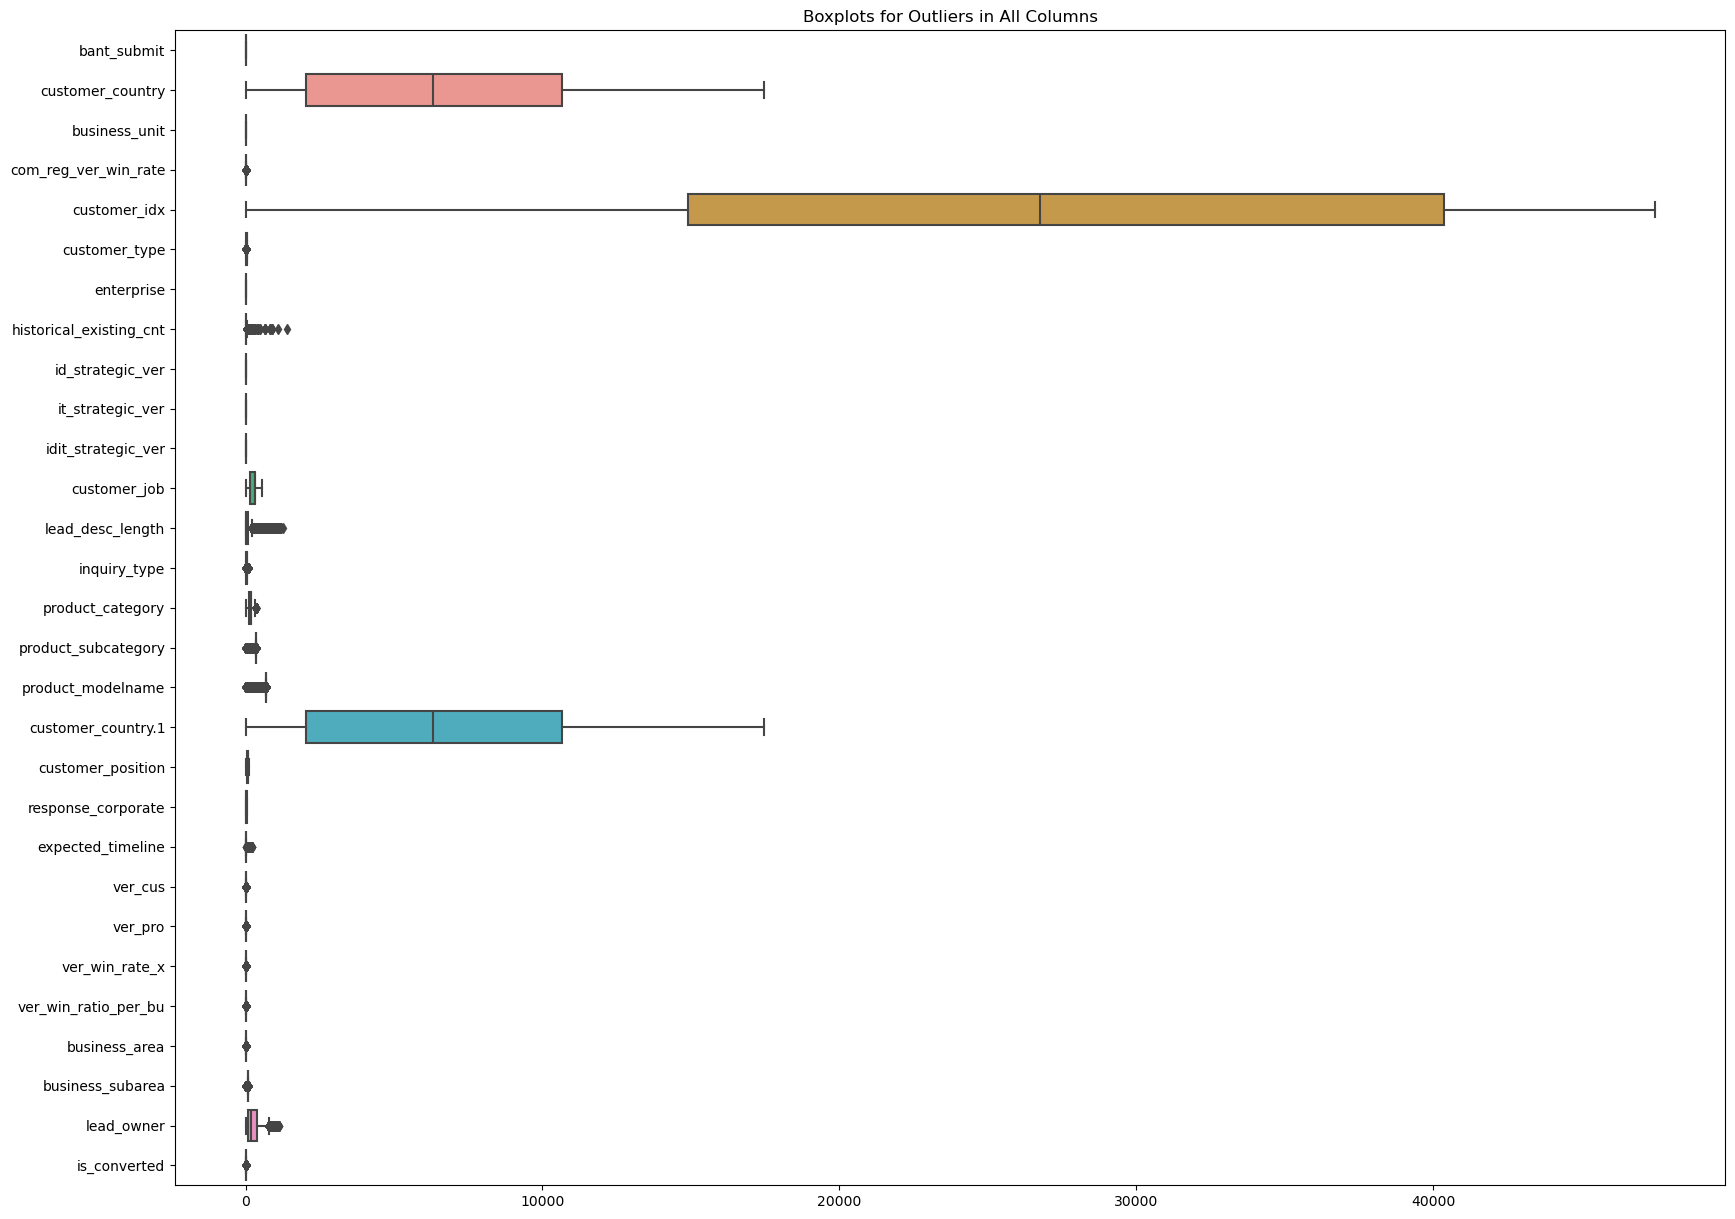

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 모든 열에 대한 상자그림 플로팅
plt.figure(figsize=(20, 15))
sns.boxplot(data=df_train, orient="h")  # orient="h"는 가로 방향 상자그림을 의미합니다
plt.title('Boxplots for Outliers in All Columns')
plt.show()


In [20]:
print(df_train.describe())

        bant_submit  customer_country  business_unit  com_reg_ver_win_rate  \
count  59299.000000      59299.000000   59299.000000          14568.000000   
mean       0.634593       7072.925041       1.320494              0.091685   
std        0.286066       4681.083682       1.172829              0.150988   
min        0.000000          0.000000       0.000000              0.003788   
25%        0.500000       2048.500000       0.000000              0.019900   
50%        0.500000       6298.000000       2.000000              0.049180   
75%        1.000000      10645.500000       2.000000              0.074949   
max        1.000000      17480.000000       4.000000              1.000000   

       customer_idx  customer_type    enterprise  historical_existing_cnt  \
count  59299.000000   59299.000000  59299.000000             13756.000000   
mean   27114.556333      27.765612      0.362839                19.912184   
std    14653.911888       9.794529      0.480823                44

        bant_submit  customer_country  business_unit  com_reg_ver_win_rate  \
count  59299.000000      59299.000000   59299.000000          14568.000000   
mean       0.634593       7072.925041       1.320494              0.091685   
std        0.286066       4681.083682       1.172829              0.150988   
min        0.000000          0.000000       0.000000              0.003788   
25%        0.500000       2048.500000       0.000000              0.019900   
50%        0.500000       6298.000000       2.000000              0.049180   
75%        1.000000      10645.500000       2.000000              0.074949   
max        1.000000      17480.000000       4.000000              1.000000   

       customer_idx  customer_type    enterprise  historical_existing_cnt  \
count  59299.000000   59299.000000  59299.000000             13756.000000   
mean   27114.556333      27.765612      0.362839                19.912184   
std    14653.911888       9.794529      0.480823                44

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


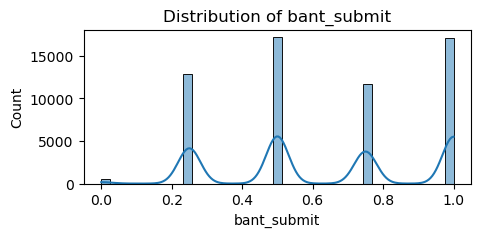

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


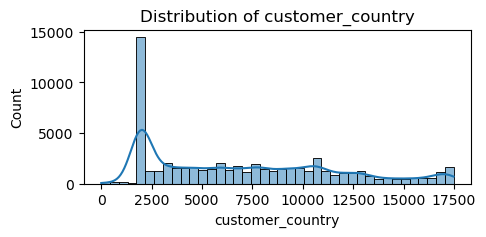

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


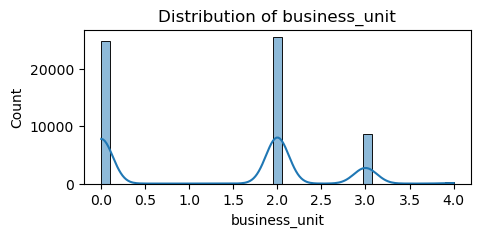

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


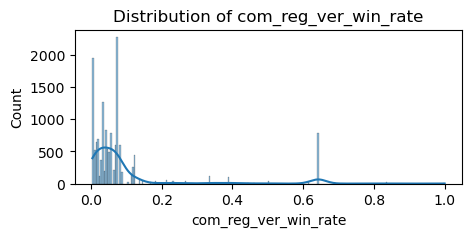

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


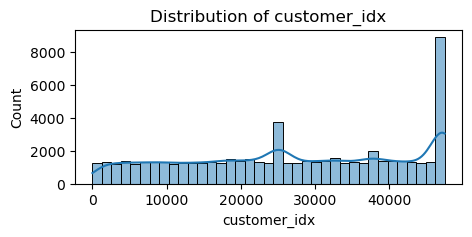

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


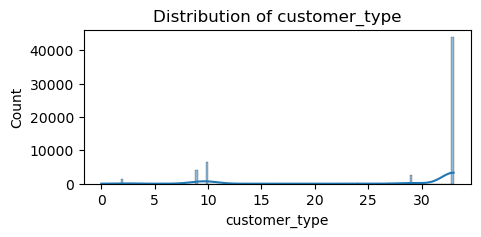

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


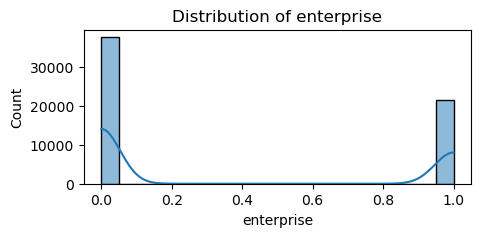

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


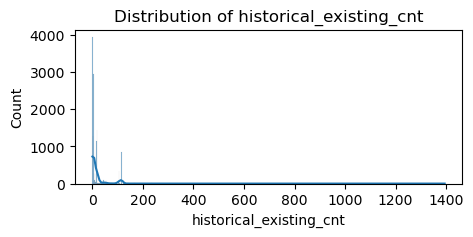

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


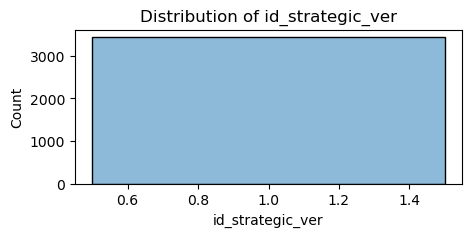

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


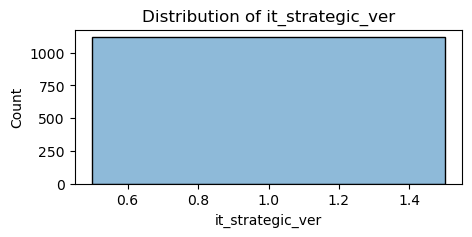

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


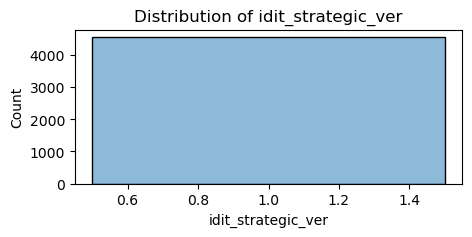

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


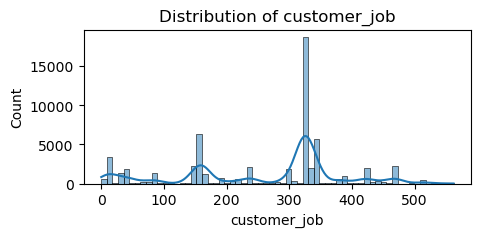

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


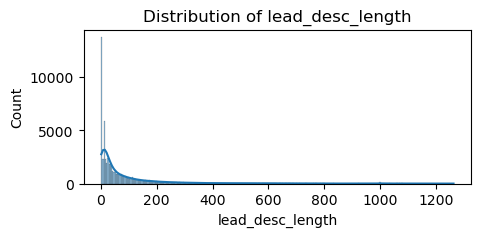

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


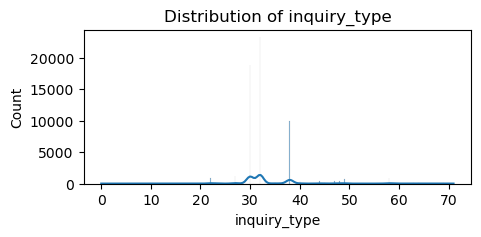

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


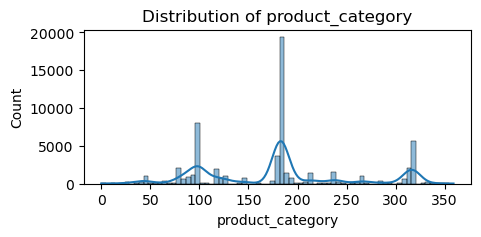

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


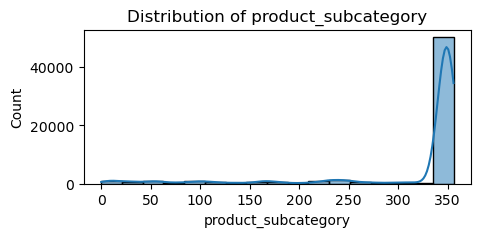

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


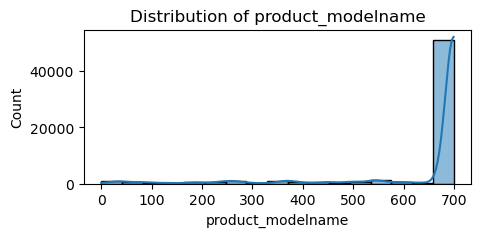

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


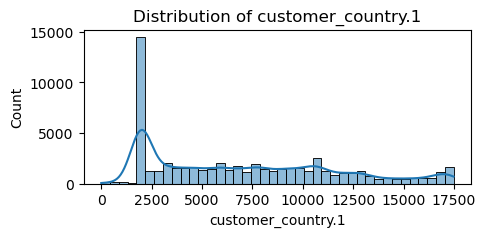

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


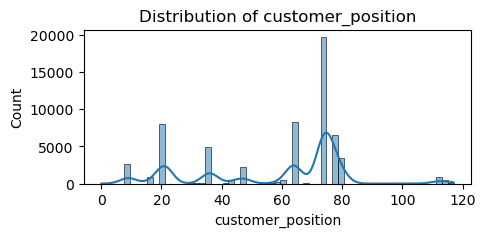

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


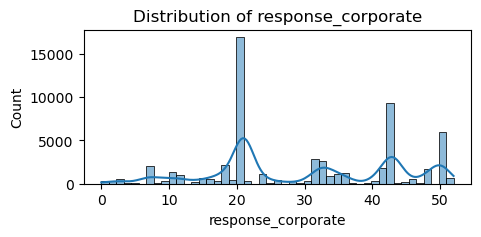

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


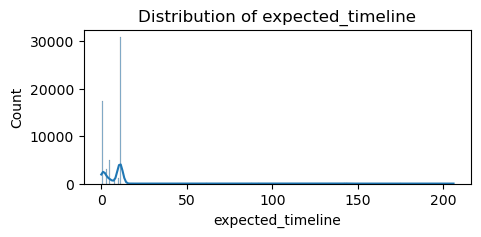

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


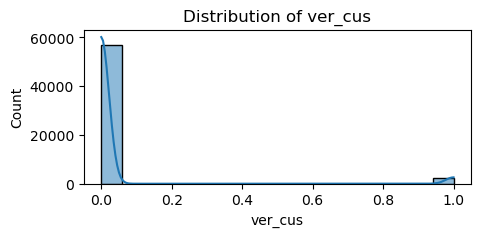

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


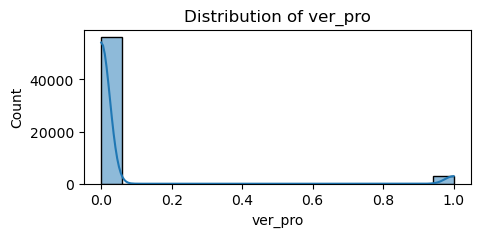

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


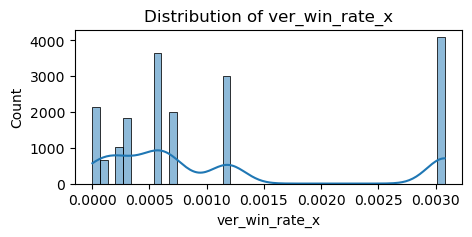

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


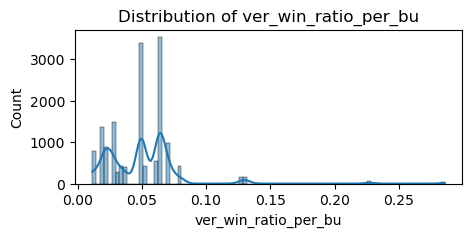

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


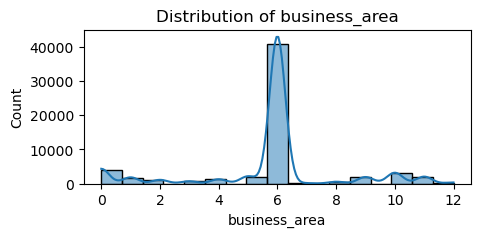

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


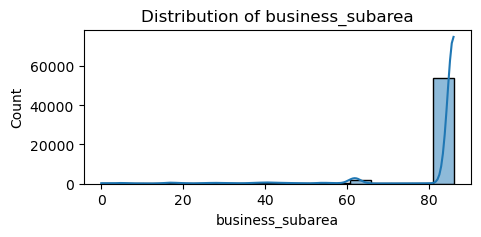

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


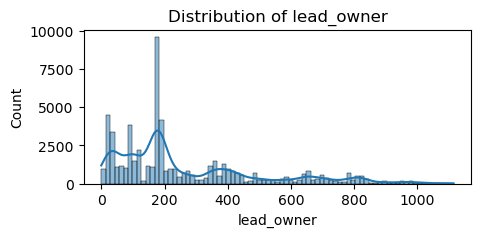

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)


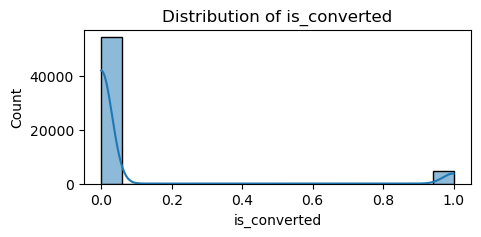

In [21]:

# 각 열에 대한 기술 통계량 출력
print(df_train.describe())

# 각 열의 분포 시각화 (히스토그램, 상자 그림)
for column in df_train.columns:
    plt.figure(figsize=(5, 2))
    sns.histplot(df_train[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


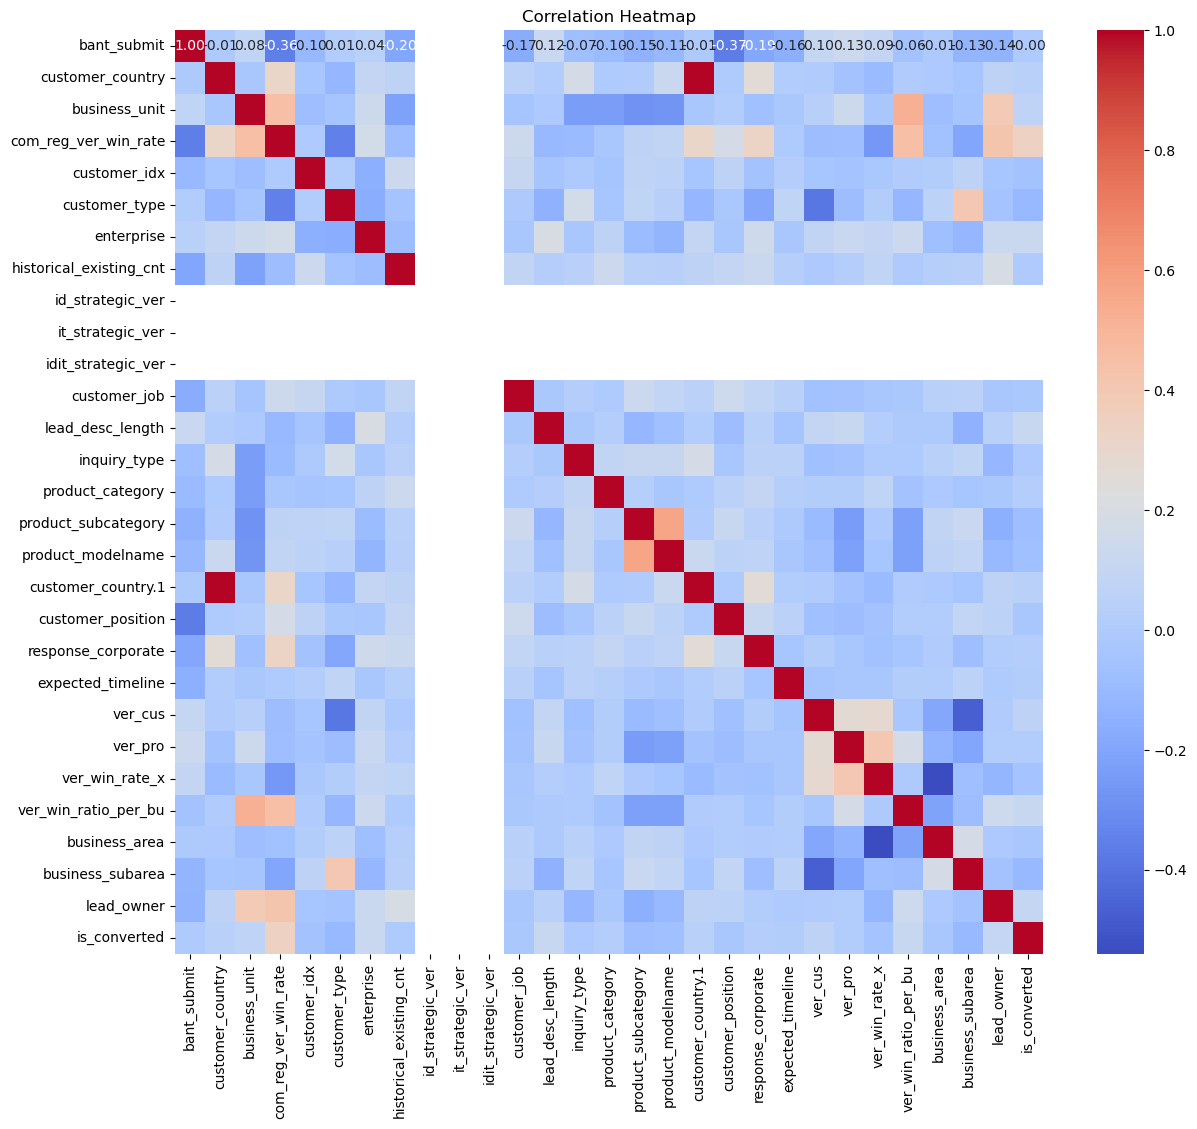

In [22]:
# 각 열의 상관 관계 히트맵
correlation_matrix = df_train.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [23]:
# NaN 값 확인
nan_values = df_train.isnull().sum()
print("NaN Values:\n", nan_values)

df_train = df_train.fillna(0)

NaN Values:
 bant_submit                    0
customer_country               0
business_unit                  0
com_reg_ver_win_rate       44731
customer_idx                   0
customer_type                  0
enterprise                     0
historical_existing_cnt    45543
id_strategic_ver           55855
it_strategic_ver           58178
idit_strategic_ver         54734
customer_job                   0
lead_desc_length               0
inquiry_type                   0
product_category               0
product_subcategory            0
product_modelname              0
customer_country.1             0
customer_position              0
response_corporate             0
expected_timeline              0
ver_cus                        0
ver_pro                        0
ver_win_rate_x             40882
ver_win_ratio_per_bu       43995
business_area                  0
business_subarea               0
lead_owner                     0
is_converted                   0
dtype: int64


In [24]:
# 무한대 값 확인
inf_values = df_train[df_train == np.inf].sum()
print("Infinite Values:\n", inf_values)

Infinite Values:
 bant_submit                0.0
customer_country           0.0
business_unit              0.0
com_reg_ver_win_rate       0.0
customer_idx               0.0
customer_type              0.0
enterprise                 0.0
historical_existing_cnt    0.0
id_strategic_ver           0.0
it_strategic_ver           0.0
idit_strategic_ver         0.0
customer_job               0.0
lead_desc_length           0.0
inquiry_type               0.0
product_category           0.0
product_subcategory        0.0
product_modelname          0.0
customer_country.1         0.0
customer_position          0.0
response_corporate         0.0
expected_timeline          0.0
ver_cus                    0.0
ver_pro                    0.0
ver_win_rate_x             0.0
ver_win_ratio_per_bu       0.0
business_area              0.0
business_subarea           0.0
lead_owner                 0.0
is_converted                 0
dtype: object


1. 결측값 처리


2. 표준편차가 큰 열 처리:
해결방안:
표준화 (Standardization) 또는 정규화 (Normalization): 데이터의 스케일을 맞춰주어 표준편차가 큰 열의 영향을 줄일 수 있습니다. 주로 Z-score 표준화나 Min-Max 정규화를 사용합니다.



3. 이진 변수의 클래스 불균형 처리:
해결방안:
클래스 가중치 설정: 클래스의 불균형이 큰 경우, 모델 학습 시 클래스에 가중치를 부여하여 균형을 맞출 수 있습니다.

In [25]:
import pandas as pd

# df_train은 데이터프레임 객체라고 가정합니다.
# 'expected_timeline' 열과 다른 열들 간의 상관 관계 확인
correlation_matrix = df_train.corrwith(df_train['expected_timeline'])

# 출력
print("상관 관계:")
print(correlation_matrix)


상관 관계:
bant_submit               -0.157194
customer_country           0.011491
business_unit             -0.021742
com_reg_ver_win_rate       0.007128
customer_idx               0.023299
customer_type              0.075634
enterprise                -0.028445
historical_existing_cnt    0.020300
id_strategic_ver           0.022189
it_strategic_ver           0.004989
idit_strategic_ver         0.022019
customer_job               0.042463
lead_desc_length          -0.042979
inquiry_type               0.052245
product_category           0.027585
product_subcategory       -0.007301
product_modelname         -0.030536
customer_country.1         0.011491
customer_position          0.049706
response_corporate        -0.035897
expected_timeline          1.000000
ver_cus                   -0.045540
ver_pro                   -0.025356
ver_win_rate_x            -0.009810
ver_win_ratio_per_bu       0.018893
business_area              0.007919
business_subarea           0.060113
lead_owner           

In [26]:
import pandas as pd
import numpy as np

# df_train은 데이터프레임 객체라고 가정합니다.
unique_values = df_train['expected_timeline'].unique()

# 최솟값과 최댓값 출력
min_value = np.min(unique_values)
max_value = np.max(unique_values)

print("최솟값:", min_value)
print("최댓값:", max_value)

# 각 숫자의 빈도 출력
value_counts = df_train['expected_timeline'].value_counts()
print("각 숫자의 빈도:")
print(value_counts)



최솟값: 0
최댓값: 206
각 숫자의 빈도:
expected_timeline
11     30863
1      17326
5       5035
3       3028
10      1107
       ...  
77         1
4          1
172        1
179        1
170        1
Name: count, Length: 207, dtype: int64


### 2-2. 학습, 검증 데이터 분리

In [27]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)





## 3. 모델 학습

### 모델 정의 

In [28]:
model = DecisionTreeClassifier()

### 모델 학습

In [29]:
model.fit(x_train.fillna(0), y_train)

DecisionTreeClassifier()

### 모델 성능 보기

In [30]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [31]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

오차행렬:
 [[  742   205]
 [  267 10646]]

정확도: 0.9602
정밀도: 0.7354
재현율: 0.7835
F1: 0.7587


## 4. 제출하기

### 테스트 데이터 예측

In [32]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [33]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

1154

### 제출 파일 작성

In [34]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**